In [2]:
import numpy as np
import urllib.request as urllib
import os

import io
from PIL import Image

import matplotlib.pyplot as plt

cam2 = "http://orangepi:8080/video.mjpg"

stream=urllib.urlopen(cam2)
# bytes=b''
# kill = 9
# f = []
# while True and kill > 0:
#     # to read mjpeg frame -
#     bytes+=stream.read(1024)
#     a = bytes.find(b'\xff\xd8')
#     b = bytes.find(b'\xff\xd9')
#     if a!=-1 and b!=-1:
#         jpg = bytes[a:b+2]
#         bytes= bytes[b+2:]
#         # we now have frame stored in frame.
#         frame = Image.open(io.BytesIO(jpg))
#         f.append(frame)
#         kill -= 1

In [3]:
# l = len(f)
# fig, axarr = plt.subplots(1,l, figsize=(20, 10))
# _ = [axarr[i].imshow(f[i]) for i in range(l)]

In [4]:
import asyncio
from urllib.parse import urlsplit

In [5]:
url = urlsplit("http://orangepi:8080/video.mjpg")

In [6]:
loop = asyncio.get_event_loop()
conn = asyncio.open_connection(url.hostname, url.port, loop=loop)

In [7]:
# %load receive.py
import asyncio
import asyncio_redis
import base64

def decoder(img_str):
    return base64.b64encode(img_str).decode('utf-8')

def encoder(img_str):
    return base64.b64decode(img_str.encode('utf-8'))

async def capture_stream(stream, bytes_=b'', chunksize=1024):
    while True:
        bytes_ += stream.read(chunksize)
        a = bytes_.find(b'\xff\xd8')
        b = bytes_.find(b'\xff\xd9')
        if a!=-1 and b!=-1 and a < b:
            jpg = bytes_[a:b+2]
            bytes_ = bytes_[b+2:]
            yield jpg
        
async def write_to_buffer(image, frame_no):
    conn_ = await asyncio_redis.Pool.create(host='redis', port=6379)
    f = 'frame_%05d' % frame_no
    if (frame_no % 1000) == 0:
        print(f)
    await conn_.set(f, decoder(image))
    conn_.close()

In [7]:
loop = asyncio.get_event_loop()
connection = asyncio_redis.Pool.create(host='redis', port=6379, poolsize=10)

In [8]:
from IPython import display

In [9]:
async def ring(buff_size):
    c = 0
    async for jpg in capture_stream(stream):
        await write_to_buffer(jpg, c)
        c += 1
        if c > buff_size:
            c = 0

In [10]:
loop.create_task(ring(10000))

<Task pending coro=<ring() running at <ipython-input-9-6dd5be2acfd4>:1>>

frame_00000
frame_01000
frame_02000
frame_03000
frame_04000
frame_05000
frame_06000
frame_07000
frame_08000
frame_09000


In [ ]:
l = []
ll = []
lll = []
m = 0
async def t(n):
    m = 0
    async for i in capture_stream(stream):
        await write_to_buffer(i, m, connection)
        im = Image.open(io.BytesIO(i))
        l.append(im)
        lll.append(i)
        if m > n:
            break
        m += 1

In [ ]:
future = asyncio.ensure_future(t(3))

In [ ]:
future

In [ ]:
l[0]

In [8]:
import redis

In [9]:
r = redis.StrictRedis(host='redis')

In [31]:
a = r.get('frame_10000')

In [32]:
a = encoder(a.decode('utf-8'))

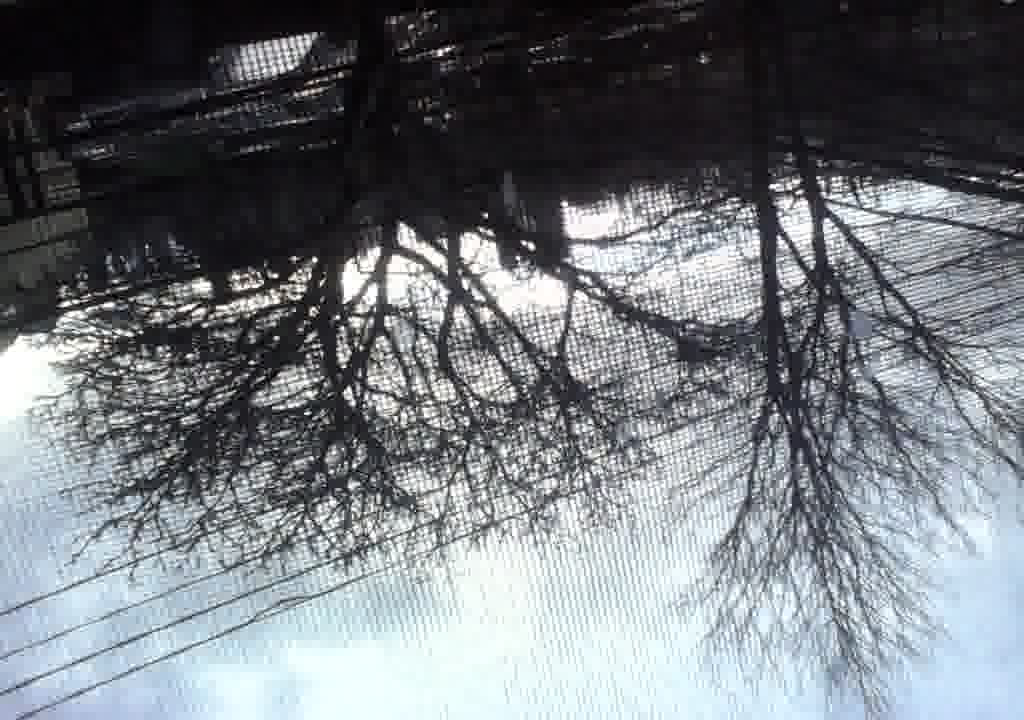

In [33]:
Image.open(io.BytesIO(a))